In [ ]:
!pip install --quiet transformers torch scipy

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import json
import os
import random

# For reproducibility
random.seed(42)

# Directory and input files
data_dir = "/content/drive/MyDrive/Master Thesis/Linguistics/Code/train_files"
input_files = ["story.json", "novel.json", "biography.json", "descriptive.json"]

# Load and collect all documents
all_docs = []
for file_name in input_files:
    path = os.path.join(data_dir, file_name)
    with open(path, "r", encoding="utf-8") as f:
        data = json.load(f)

    doc_ids = list(data["id"].values())
    domain = file_name.split(".")[0]
    for i, doc_id in enumerate(doc_ids):
        doc = {
            "id": doc_id,
            "sentences": data["sentences"][str(i)],
            "domain": domain,
        }
        if "clusters" in data and str(i) in data["clusters"]:
            doc["clusters"] = data["clusters"][str(i)]
        elif "mention_clusters" in data and str(i) in data["mention_clusters"]:
            doc["mention_clusters"] = data["mention_clusters"][str(i)]
        all_docs.append(doc)

# Shuffle and split
random.shuffle(all_docs)
total = len(all_docs)
train_split = int(0.8 * total)
dev_split = int(0.9 * total)

train_docs = all_docs[:train_split]
dev_docs = all_docs[train_split:dev_split]
test_docs = all_docs[dev_split:]

print(f"📊 Total: {total} → Train: {len(train_docs)}, Dev: {len(dev_docs)}, Test: {len(test_docs)}")

# Assign new IDs
for i, doc in enumerate(train_docs):
    doc["id"] = f"train_{i:03d}"
for i, doc in enumerate(dev_docs):
    doc["id"] = f"dev_{i:03d}"
for i, doc in enumerate(test_docs):
    doc["id"] = f"test_{i:03d}"

# Save as JSONL
output_paths = {
    "train": os.path.join(data_dir, "train.jsonl"),
    "dev": os.path.join(data_dir, "dev.jsonl"),
    "test": os.path.join(data_dir, "test.jsonl")
}

for split_name, doc_list in zip(output_paths.keys(), [train_docs, dev_docs, test_docs]):
    with open(output_paths[split_name], "w", encoding="utf-8") as f:
        for doc in doc_list:
            f.write(json.dumps(doc, ensure_ascii=False) + "\n")

print("✅ New splits written:")
for name, path in output_paths.items():
    print(f"- {name}.jsonl → {path}")

📊 Total: 122 → Train: 97, Dev: 12, Test: 13
✅ New splits written:
- train.jsonl → /content/drive/MyDrive/Master Thesis/Linguistics/Code/train_files/train.jsonl
- dev.jsonl → /content/drive/MyDrive/Master Thesis/Linguistics/Code/train_files/dev.jsonl
- test.jsonl → /content/drive/MyDrive/Master Thesis/Linguistics/Code/train_files/test.jsonl


In [ ]:
# Load the JSONL files created in Cell 3
def load_jsonl(file_path):
    data = []
    with open(file_path, "r", encoding="utf-8") as f:
        for line in f:
            data.append(json.loads(line.strip()))
    return data

# Set file paths
train_path = os.path.join(data_dir, "train.jsonl")
dev_path = os.path.join(data_dir, "dev.jsonl")
test_path = os.path.join(data_dir, "test.jsonl")

# Load splits
train_data = load_jsonl(train_path)
dev_data = load_jsonl(dev_path)
test_data = load_jsonl(test_path)

# Print some stats
print(f"📊 Train examples: {len(train_data)}")
print(f"📊 Dev examples:   {len(dev_data)}")
print(f"📊 Test examples:  {len(test_data)}")

# Preview structure of first train example
print("\n🔍 Sample train document:")
print(json.dumps(train_data[0], indent=2, ensure_ascii=False))

📊 Train examples: 97
📊 Dev examples:   12
📊 Test examples:  13

🔍 Sample train document:
{
  "id": "train_000",
  "sentences": [
    [
      "কোন",
      "জমিদার",
      "গৃহিণী",
      "ছোট",
      "ভাইয়ের",
      "বউ",
      "আনিবার",
      "জন্য",
      "ভাইয়ের",
      "শ্বশুরবাড়ী",
      "গিয়াছেন",
      "।"
    ],
    [
      "একদিন",
      "হঠাৎ",
      "গিয়া",
      "দেখেন",
      "নববধূকে",
      "তাঁহার",
      "ভ্রাতৃবধূ",
      "ভাত",
      "খাইয়াইতেছেন",
      "।"
    ],
    [
      "ভাতের",
      "বাসনে",
      "একটা",
      "কাঁচা",
      "মরিচ",
      "ছিল",
      "।"
    ],
    [
      "তিনি",
      "সরল",
      "মনে",
      "জিজ্ঞাসা",
      "করিলেন",
      ",",
      "“",
      "আমাদের",
      "বউ",
      "ঝাল",
      "খাইতে",
      "ভালবাসে",
      "নাকি",
      "?",
      "”"
    ],
    [
      "বউয়ের",
      "ভাবীজান",
      "উত্তর",
      "দিলেন",
      ",",
      "“",
      "হ্যাঁ",
      ",",
      "বড্ড",
      "ঝাল",
      "খায়",
      "!",
      "”"
 

In [ ]:
# Preview structure of first train example more detailed
sample_doc = train_data[1]
print("\nSample train document summary:")
print(f"ID: {sample_doc['id']}")
print(f"Domain: {sample_doc['domain']}")
print(f"Number of sentences: {len(sample_doc['sentences'])}")
print("First 5 sentences:")
for i, sent in enumerate(sample_doc['sentences'][:5]):
  print(f"Sentence {i+1}: {' '.join(sent)}")
if 'mention_clusters' in sample_doc:
  clusters_key = 'mention_clusters'
elif 'clusters' in sample_doc:
  clusters_key = 'clusters'
else:
  clusters_key = None
if clusters_key:
  print(f"\nNumber of clusters: {len(sample_doc[clusters_key])}")
  print("First 5 clusters:")
for i, cluster in enumerate(sample_doc[clusters_key][:5]):
  print(f"Cluster {i+1}: {cluster}")
else:
  print("\nNo clusters found in sample.")


Sample train document summary:
ID: train_001
Domain: descriptive
Number of sentences: 12
First 5 sentences:
Sentence 1: ইনফ্লুয়েঞ্জা ( Influenza ) শ্বাসতন্ত্রের একটি তীব্র সংক্রামক রোগ ।
Sentence 2: ‘ ফ্লু ’ নামেও পরিচিত এই রোগের কারণ এক ধরনের ভাইরাস ।
Sentence 3: ইতিহাসে সর্বাধিক পরিচিত মহামারীর মধ্যে ১৯১৮ সালের ইনফ্লুয়েঞ্জা মহামারীই সবচেয়ে ভয়ঙ্কর ।
Sentence 4: এতে গোটা পৃথিবীতে প্রায় ২ কোটি লোক প্রাণ হারায় ।
Sentence 5: রোগলক্ষণের মধ্যে কাশি , স্বরভঙ্গ , সর্দি , জ্বর ও গায়ে ব্যথাই প্রধান ।

Number of clusters: 1
First 5 clusters:
Cluster 1: [[0, 0, 0], [0, 8, 8], [1, 1, 1], [1, 5, 6], [2, 7, 7], [3, 0, 0], [5, 3, 3], [7, 3, 3], [8, 13, 13], [10, 13, 13], [10, 21, 21], [11, 12, 12]]

No clusters found in sample.


In [ ]:
from transformers import AutoTokenizer, AutoModel
import torch

# Load the tokenizer and model from HuggingFace
model_name = "csebuetnlp/banglabert"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModel.from_pretrained(model_name)

# Move model to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)
model.eval()

print("✅ BanglaBERT loaded on:", device)

✅ BanglaBERT loaded on: cpu


In [ ]:
from typing import List, Dict, Tuple

def get_mention_embeddings(sentences: List[List[str]], clusters: List[List[List[int]]]):
    """
    For a single document, compute embeddings for each gold mention.
    Returns:
      mention_id_map: {(sent_id, start, end): mention_id}
      mention_embeds: {mention_id: tensor}
      gold_clusters: [[mention_id, mention_id, ...], ...]
    """
    mention_embeds = {}
    gold_clusters = []
    mention_id_map = {}
    mention_counter = 0

    # Assign unique IDs to mentions
    for cluster in clusters:
        cluster_ids = []
        for (sent_id, start, end) in cluster:
            m_id = f"m{mention_counter}"
            mention_id_map[(sent_id, start, end)] = m_id
            cluster_ids.append(m_id)
            mention_counter += 1
        gold_clusters.append(cluster_ids)

    # Group mentions by sentence
    mentions_by_sentence = {}
    for (sent_id, start, end), m_id in mention_id_map.items():
        mentions_by_sentence.setdefault(sent_id, []).append((start, end, m_id))

    # Encode each sentence and its mentions
    for sent_id, tokens in enumerate(sentences):
        if sent_id not in mentions_by_sentence:
            continue
        text = " ".join(tokens)
        tokenized = tokenizer(text, return_offsets_mapping=True, return_tensors="pt", add_special_tokens=False)
        input_ids = tokenized["input_ids"].to(device)
        offsets = tokenized["offset_mapping"][0].tolist()
        with torch.no_grad():
            outputs = model(input_ids)
            embeddings = outputs.last_hidden_state[0]  # (seq_len, hidden_dim)

        # Align mentions
        for start_tok, end_tok, m_id in mentions_by_sentence[sent_id]:
            # Convert word token span to character span
            if start_tok == 0:
                char_start = 0
            else:
                char_start = len(" ".join(tokens[:start_tok])) + 1
            char_end = len(" ".join(tokens[:end_tok + 1]))

            # Match wordpieces whose char offsets are within this span
            span_embeds = []
            for idx, (start_char, end_char) in enumerate(offsets):
                if end_char > 0 and start_char >= char_start and end_char <= char_end:
                    span_embeds.append(embeddings[idx])
            if span_embeds:
                span_tensor = torch.stack(span_embeds, dim=0)
                mention_embeds[m_id] = torch.mean(span_tensor, dim=0).cpu()

    return mention_id_map, mention_embeds, gold_clusters

# Create storage for all splits
all_mentions = {}       # {split: [mention_id_map for each doc]}
all_embeddings = {}     # {split: [mention_id -> embedding tensor]}
all_gold_clusters = {}  # {split: [list of gold clusters as mention_ids]}

for split_name, split_data in zip(["train", "dev", "test"], [train_data, dev_data, test_data]):
    print(f"📂 Processing {split_name} set ({len(split_data)} docs)...")
    all_mentions[split_name] = []
    all_embeddings[split_name] = []
    all_gold_clusters[split_name] = []

    for doc in split_data:
        sentences = doc["sentences"]
        clusters = doc.get("clusters", doc.get("mention_clusters", []))
        mention_map, mention_embs, gold_clusts = get_mention_embeddings(sentences, clusters)

        all_mentions[split_name].append(mention_map)
        all_embeddings[split_name].append(mention_embs)
        all_gold_clusters[split_name].append(gold_clusts)

    print(f"✅ Done: {split_name} set")

📂 Processing train set (97 docs)...
✅ Done: train set
📂 Processing dev set (12 docs)...
✅ Done: dev set
📂 Processing test set (13 docs)...
✅ Done: test set


In [ ]:
import torch.nn.functional as F

def cosine_sim(a: torch.Tensor, b: torch.Tensor) -> float:
    return F.cosine_similarity(a.unsqueeze(0), b.unsqueeze(0)).item()

def cluster_mentions_greedy(mention_ids: List[str], mention_embeds: Dict[str, torch.Tensor], threshold: float = 0.5):
    """
    Greedy coreference clustering based on cosine similarity.
    Returns: List of clusters (each is a list of mention_ids)
    """
    clusters = []
    mention_to_cluster = {}

    for i, m_id in enumerate(mention_ids):
        best_sim = -1.0
        best_ante = None

        for j in range(i):  # look only at previous mentions
            prev_id = mention_ids[j]
            if prev_id not in mention_embeds or m_id not in mention_embeds:
                continue
            sim = cosine_sim(mention_embeds[m_id], mention_embeds[prev_id])
            if sim > best_sim:
                best_sim = sim
                best_ante = prev_id

        # Link if similar enough
        if best_sim >= threshold and best_ante is not None:
            cluster_idx = mention_to_cluster.get(best_ante)
            if cluster_idx is not None:
                clusters[cluster_idx].append(m_id)
                mention_to_cluster[m_id] = cluster_idx
            else:
                # Create a new cluster with both
                new_cluster = [best_ante, m_id]
                clusters.append(new_cluster)
                new_idx = len(clusters) - 1
                mention_to_cluster[best_ante] = new_idx
                mention_to_cluster[m_id] = new_idx
        else:
            # Start new cluster
            clusters.append([m_id])
            mention_to_cluster[m_id] = len(clusters) - 1

    return clusters

# Store predicted clusters
all_pred_clusters = {}  # {split: list of [clusters per doc]}

for split in ["train", "dev", "test"]:
    print(f"🤖 Predicting clusters for {split} set...")
    all_pred_clusters[split] = []

    for i in range(len(all_mentions[split])):
        mention_map = all_mentions[split][i]         # {(sent_id, start, end): mention_id}
        mention_embs = all_embeddings[split][i]       # {mention_id: embedding}

        # Sort mentions by sentence index for deterministic ordering
        sorted_mentions = sorted(mention_map.items(), key=lambda x: (x[0][0], x[0][1], x[0][2]))
        mention_ids = [m_id for _, m_id in sorted_mentions if m_id in mention_embs]

        # Cluster them
        pred_clusters = cluster_mentions_greedy(mention_ids, mention_embs, threshold=0.5)
        all_pred_clusters[split].append(pred_clusters)

    print(f"✅ Done: {split} set → {len(all_pred_clusters[split])} docs clustered.")

🤖 Predicting clusters for train set...
✅ Done: train set → 97 docs clustered.
🤖 Predicting clusters for dev set...
✅ Done: dev set → 12 docs clustered.
🤖 Predicting clusters for test set...
✅ Done: test set → 13 docs clustered.


In [ ]:
from scipy.optimize import linear_sum_assignment
import numpy as np

# --- MUC ---
def muc_score(gold, pred):
    gold_index = {m: i for i, c in enumerate(gold) for m in c}
    pred_index = {m: i for i, c in enumerate(pred) for m in c}

    # Recall
    numer_r = denom_r = 0
    for cluster in gold:
        if len(cluster) <= 1: continue
        denom_r += len(cluster) - 1
        pred_links = set(pred_index.get(m, -1) for m in cluster)
        numer_r += len(cluster) - len(pred_links)

    # Precision
    numer_p = denom_p = 0
    for cluster in pred:
        if len(cluster) <= 1: continue
        denom_p += len(cluster) - 1
        gold_links = set(gold_index.get(m, -1) for m in cluster)
        numer_p += len(cluster) - len(gold_links)

    recall = numer_r / denom_r if denom_r else 0
    precision = numer_p / denom_p if denom_p else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return recall, precision, f1

# --- B3 ---
def b3_score(gold, pred):
    gold_index = {m: i for i, c in enumerate(gold) for m in c}
    pred_index = {m: i for i, c in enumerate(pred) for m in c}
    mention_set = set(gold_index) | set(pred_index)
    total = len(mention_set)
    sum_r = sum_p = 0

    for m in mention_set:
        g = set(gold[gold_index[m]]) if m in gold_index else set()
        p = set(pred[pred_index[m]]) if m in pred_index else set()
        if not g or not p: continue
        inter = len(g & p)
        sum_r += inter / len(g)
        sum_p += inter / len(p)

    recall = sum_r / total if total else 0
    precision = sum_p / total if total else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return recall, precision, f1

# --- CEAF (mention-based) ---
def ceaf_score(gold, pred):
    sim = np.zeros((len(gold), len(pred)))
    for i, g in enumerate(gold):
        for j, p in enumerate(pred):
            sim[i, j] = len(set(g) & set(p))
    row_ind, col_ind = linear_sum_assignment(-sim)
    matching = sim[row_ind, col_ind].sum()
    recall = matching / sum(len(c) for c in gold) if gold else 0
    precision = matching / sum(len(c) for c in pred) if pred else 0
    f1 = 2 * precision * recall / (precision + recall) if (precision + recall) else 0
    return recall, precision, f1

# Helper function to evaluate one split
def evaluate_coref(split_name):
    if split_name == "dev":
        split_data = dev_data
    elif split_name == "test":
        split_data = test_data
    else:
        return

    domains = ["biography", "descriptive", "novel", "story"]

    for domain in domains:
        domain_indices = [i for i, doc in enumerate(split_data) if doc["domain"] == domain]
        if not domain_indices:
            continue
        muc_r, muc_p, muc_f = 0, 0, 0
        b3_r, b3_p, b3_f = 0, 0, 0
        ceaf_r, ceaf_p, ceaf_f = 0, 0, 0
        n_docs = len(domain_indices)

        for i in domain_indices:
            gold = all_gold_clusters[split_name][i]
            pred = all_pred_clusters[split_name][i]

            r, p, f = muc_score(gold, pred)
            muc_r += r; muc_p += p; muc_f += f

            r, p, f = b3_score(gold, pred)
            b3_r += r; b3_p += p; b3_f += f

            r, p, f = ceaf_score(gold, pred)
            ceaf_r += r; ceaf_p += p; ceaf_f += f

        # Average over all documents in domain
        muc = (muc_r / n_docs, muc_p / n_docs, muc_f / n_docs)
        b3 = (b3_r / n_docs, b3_p / n_docs, b3_f / n_docs)
        ceaf = (ceaf_r / n_docs, ceaf_p / n_docs, ceaf_f / n_docs)
        conll_f1 = (muc[2] + b3[2] + ceaf[2]) / 3

        print(f"\n📊 CoNLL Evaluation on {split_name.upper()} Set for {domain.upper()}:")
        print(f"MUC   - R: {muc[0]:.3f}, P: {muc[1]:.3f}, F1: {muc[2]:.3f}")
        print(f"B³    - R: {b3[0]:.3f}, P: {b3[1]:.3f}, F1: {b3[2]:.3f}")
        print(f"CEAF  - R: {ceaf[0]:.3f}, P: {ceaf[1]:.3f}, F1: {ceaf[2]:.3f}")
        print(f"🔁 CoNLL Average F1: {conll_f1:.3f}")

# Evaluate on dev and test sets
evaluate_coref("dev")
evaluate_coref("test")


📊 CoNLL Evaluation on DEV Set for BIOGRAPHY:
MUC   - R: 0.960, P: 0.921, F1: 0.939
B³    - R: 0.882, P: 0.656, F1: 0.720
CEAF  - R: 0.708, P: 0.708, F1: 0.708
🔁 CoNLL Average F1: 0.789

📊 CoNLL Evaluation on DEV Set for DESCRIPTIVE:
MUC   - R: 0.983, P: 0.918, F1: 0.949
B³    - R: 0.876, P: 0.596, F1: 0.669
CEAF  - R: 0.626, P: 0.626, F1: 0.626
🔁 CoNLL Average F1: 0.748

📊 CoNLL Evaluation on DEV Set for NOVEL:
MUC   - R: 0.913, P: 0.875, F1: 0.894
B³    - R: 0.747, P: 0.416, F1: 0.534
CEAF  - R: 0.500, P: 0.500, F1: 0.500
🔁 CoNLL Average F1: 0.643

📊 CoNLL Evaluation on DEV Set for STORY:
MUC   - R: 0.958, P: 0.911, F1: 0.934
B³    - R: 0.826, P: 0.481, F1: 0.593
CEAF  - R: 0.570, P: 0.570, F1: 0.570
🔁 CoNLL Average F1: 0.699

📊 CoNLL Evaluation on TEST Set for BIOGRAPHY:
MUC   - R: 0.954, P: 1.000, F1: 0.976
B³    - R: 0.819, P: 1.000, F1: 0.899
CEAF  - R: 0.897, P: 0.897, F1: 0.897
🔁 CoNLL Average F1: 0.924

📊 CoNLL Evaluation on TEST Set for DESCRIPTIVE:
MUC   - R: 0.956, P: 0.929

Table:
     Domain Split         Source  MUC F1  B³ F1  CEAF F1  CoNLL Avg F1
  Biography   Dev    My Baseline    93.9   72.0     70.8          78.9
  Biography  Test    My Baseline    97.6   89.9     89.7          92.4
  Biography  Test BenCoref Paper    89.8   79.0     53.3          74.0
Descriptive   Dev    My Baseline    94.9   66.9     62.6          74.8
Descriptive  Test    My Baseline    94.2   62.3     62.0          72.8
Descriptive  Test BenCoref Paper    57.4   37.7     35.0          43.4
      Novel   Dev    My Baseline    89.4   53.4     50.0          64.3
      Novel  Test    My Baseline     NaN    NaN      NaN           NaN
      Novel  Test BenCoref Paper    60.3   38.1     33.9          44.1
      Story   Dev    My Baseline    93.4   59.3     57.0          69.9
      Story  Test    My Baseline    90.6   56.6     54.8          67.3
      Story  Test BenCoref Paper    62.5   40.1     33.6          45.4


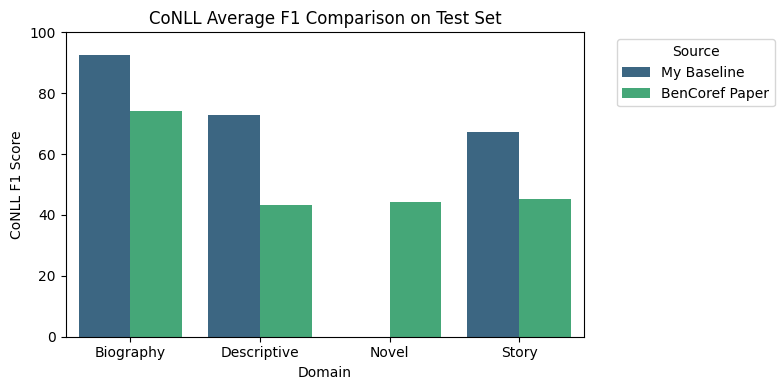

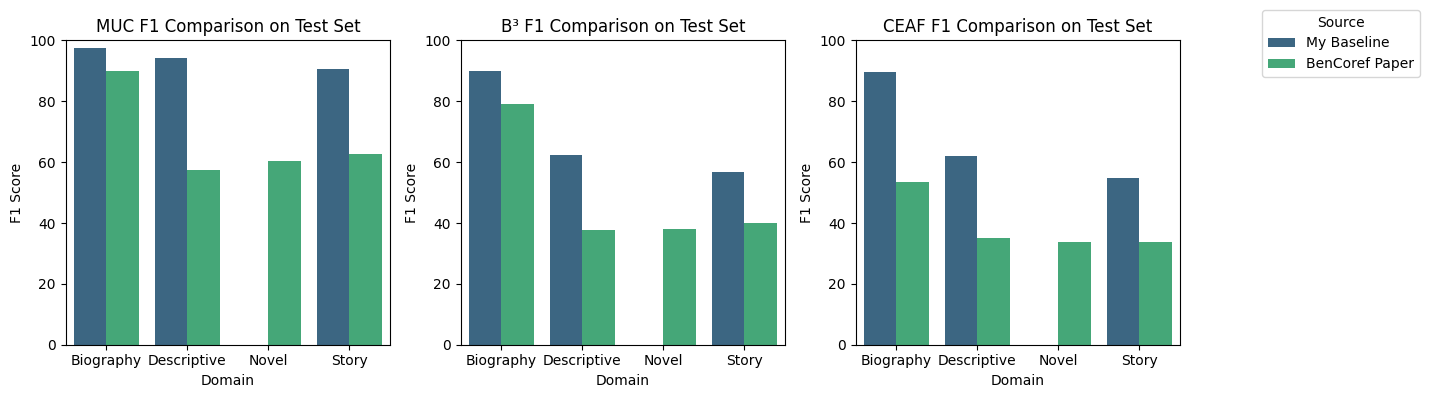

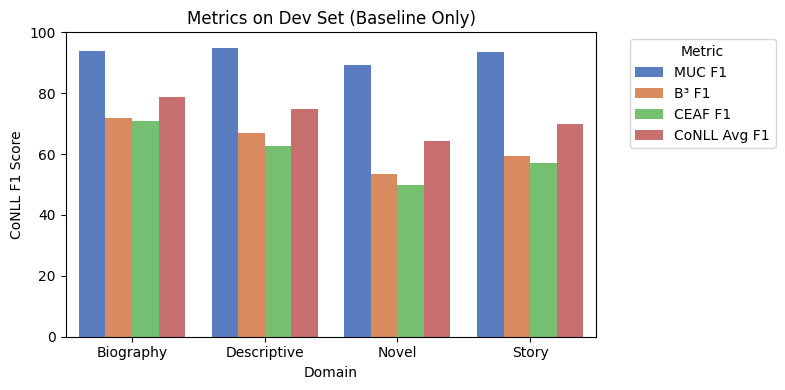

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Data from the table
data = {
    'Domain': ['Biography', 'Biography', 'Biography',
               'Descriptive', 'Descriptive', 'Descriptive',
               'Novel', 'Novel', 'Novel',
               'Story', 'Story', 'Story'],
    'Split': ['Dev', 'Test', 'Test',
              'Dev', 'Test', 'Test',
              'Dev', 'Test', 'Test',
              'Dev', 'Test', 'Test'],
    'Source': ['My Baseline', 'My Baseline', 'BenCoref Paper',
               'My Baseline', 'My Baseline', 'BenCoref Paper',
               'My Baseline', 'My Baseline', 'BenCoref Paper',
               'My Baseline', 'My Baseline', 'BenCoref Paper'],
    'MUC F1': [93.9, 97.6, 89.8,
               94.9, 94.2, 57.4,
               89.4, None, 60.3,
               93.4, 90.6, 62.5],
    'B³ F1': [72.0, 89.9, 79.0,
              66.9, 62.3, 37.7,
              53.4, None, 38.1,
              59.3, 56.6, 40.1],
    'CEAF F1': [70.8, 89.7, 53.3,
                62.6, 62.0, 35.0,
                50.0, None, 33.9,
                57.0, 54.8, 33.6],
    'CoNLL Avg F1': [78.9, 92.4, 74.0,
                     74.8, 72.8, 43.4,
                     64.3, None, 44.1,
                     69.9, 67.3, 45.4]
}

df = pd.DataFrame(data)

# Display the table
print("Table:")
print(df.to_string(index=False))

# Filter for Test split for comparison
df_test = df[df['Split'] == 'Test'].dropna()

# Plot CoNLL Avg F1 for all domains on Test - Compact
plt.figure(figsize=(8, 4))
sns.barplot(data=df_test, x='Domain', y='CoNLL Avg F1', hue='Source', palette='viridis')
plt.title('CoNLL Average F1 Comparison on Test Set')
plt.ylabel('CoNLL F1 Score')
plt.ylim(0, 100)
plt.legend(title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot individual metrics for Test - Compact
metrics = ['MUC F1', 'B³ F1', 'CEAF F1']
fig, axes = plt.subplots(1, 3, figsize=(12, 4))
for i, metric in enumerate(metrics):
    sns.barplot(ax=axes[i], data=df_test, x='Domain', y=metric, hue='Source', palette='viridis')
    axes[i].set_title(f'{metric} Comparison on Test Set')
    axes[i].set_ylabel('F1 Score')
    axes[i].set_ylim(0, 100)
    axes[i].legend().remove()  # Remove individual legends
fig.legend(handles=axes[0].get_legend_handles_labels()[0], labels=['My Baseline', 'BenCoref Paper'], title='Source', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()

# Plot for Dev split (only Baseline) - Compact
df_dev = df[df['Split'] == 'Dev']
plt.figure(figsize=(8, 4))
sns.barplot(data=df_dev.melt(id_vars=['Domain', 'Split', 'Source'], value_vars=['MUC F1', 'B³ F1', 'CEAF F1', 'CoNLL Avg F1']),
            x='Domain', y='value', hue='variable', palette='muted')
plt.title('Metrics on Dev Set (Baseline Only)')
plt.ylabel('CoNLL F1 Score')
plt.ylim(0, 100)
plt.legend(title='Metric', bbox_to_anchor=(1.05, 1), loc='upper left')
plt.tight_layout()
plt.show()